# Ćwiczenie 2 - Algorytmy ewolucyjne i genetyczne
## Implementacja algorytmu ewolucyjnego z selekcją ruletkową, krzyżowaniem jednopunktowym, mutacją gaussowską oraz sukcesją generacyjną.

### Importowanie modułów
- potrzebnych do wykonania ćwiczenia. W realizacji algorytmu korzystam z biblioteki math, random, numpy oraz copy,

In [1]:
import math
import random
import numpy as np
import copy
from typing import List, Tuple

- potrzebnych do wygenerowania wykresów stanowiących wizualizację działania algorytmu.

In [2]:
import matplotlib.pyplot as plt

### Definicja klasy FactoryResource

Na potrzeby ćwiczenia definiujemy klasę FactoryResource. Reprezentuje ona "zakłady" dostarczające zasoby, z jakich nasza fabryka (której optymalne położenie będziemy później za pomocą algorytmu ewolucyjnego poszukiwać) będzie korzystać. Klasa ta przechowuje informacje takie jak:
 - *nazwa zakładu* - w celu ich uporządkowania jako nazwy przyjęłam kolejne liczby naturalne),
  - *współrzędne* - określają dokładne położenie zakładu w przestrzeni badanej R<sup>n</sup>,
  - *ilość dostarczanych zasobów* - mówi nam, ile zasobów dany zakład przekazuje naszej fabryce (jest to istotne w dalszych obliczeniach m.in. kosztu ich transportu).

Oprócz konstruktora klasy, został zaimplementowany niezbędny getter - do współrzędnych danego zakładu.

In [3]:
class FactoryResource:

    def __init__(self, name: int, coordinates: List[float], quantity_of_resources_provided: int = 0) -> None:
        """
        FactoryResource class constructor. It requires given parameters:
        :param name:
        :param coordinates:
        :param quantity_of_resources_provided:
        """
        self.name = name
        self.coordinates = coordinates
        self.provided_resources = quantity_of_resources_provided


    def get_coordinates(self):
        """
        Coordinates getter.
        :return: coordinates
        """
        return self.coordinates

### Definicja klasy Factory

Jest to klasa reprezentująca osobniki należące do populacji, na której przeprowadzane jest działanie algorytmu ewolucyjnego. Klasa ta w postaci atrybutów zawiera takie informacje, jak:
- *nazwa generacji* - w postaci liczby naturalnej mówi nam, jakim kolejnym pokoleniem potomków początkowej populacji jest dany osobnik (inicjująca algorytm populacja ma generację równą 1),
- *współrzędne osobnika* - lista, która zawiera współrzędne fabryki w przestrzeni n-wymiarowej (ilość współrzędnych wskazuje nam liczbę wymiarów badanego obszaru),
- *wartość otrzymana z funkcji oceny* - w formie liczby całkowitej mówi nam o jakości danego osobnika,
- *prawdopodobieństwo sukcesji* - wyliczone w oparciu o wartość otrzymanej oceny osobnika, ma wpływ na szansę osobnika na przeżycie (wybranie do sukcesji).

Oprócz konstruktora klasy (który wymaga podania jako parametrów wywołania nazwy generacji oraz współrzędnych) dla wspomnianej klasy zostały zaimplementowane niezbędne gettery oraz settery poszczególnych atrybutów.

In [4]:
class Factory:

    def __init__(self, generation: int, coordinates: List[float]) -> None:
        """
        Factory class constructor. It requires given parameters:
        :param generation: name (represented as int)
        of the generation to which given individual belongs to
        :param coordinates: individuals coordinates
        """
        self.generation_name = generation
        self.coordinates = coordinates
        self.fitness_score = float('inf')
        self.succession_probability = 0


    def get_generation_name(self):
        """
        Generation name getter.
        :return: generation_name
        """
        return self.generation_name


    def get_coordinates(self):
        """
        Coordinates getter.
        :return: coordinates
        """
        return self.coordinates


    def set_coordinates(self, new_coordinates):
        """
        Coordinates setter.
        :param new_coordinates: new provided coordinates to set
        :return: new_coordinates
        """
        self.coordinates = new_coordinates


    def set_one_coordinate(self, new_coordinate, position):
        """
        Single coordinate setter.
        :param new_coordinate: new coordinate to set
        :param position: provides information about
        which coordinate (in which dimension) needs to be altered.
        :return: new_coordinate
        """
        self.coordinates[position] = new_coordinate


    def get_fitness_score(self):
        """
        Fitness score getter.
        :return: fitness_score
        """
        return self.fitness_score


    def set_fitness_score(self, new_fitness_score: int):
        """
        Fitness score setter.
        :param new_fitness_score: updated new fitness score for the individual
        :return: new_fitness_score
        """
        self.fitness_score = new_fitness_score


    def get_succession_probability(self):
        """
        Succession probability getter.
        :return: succession_probability
        """
        return self.succession_probability


    def set_succession_probability(self, new_succession_probability):
        """
        Succession probability setter.
        :param new_succession_probability: Updated succession probability
        :return: new_succession_probability
        """
        self.succession_probability = new_succession_probability


    def __eq__(self, other_individual: 'Factory') :
        """
        Equality method overload.
        :param other_individual: instance of Factory class
        :return: boolean expression
        """
        if self.get_coordinates() == other_individual.get_coordinates():
            return True
        else:
            return False


### Definicja klasy EvolutionaryAlgorithm

Jest to klasa reprezentująca badany w tym ćwiczeniu algorytm ewolucyjny. Zawiera ona implementację algorytmu ewolucyjnego oraz stanowi swoistą pamięć dla tego algorytmu. Klasa ta została zaimplementowana w sposób jak najbardziej uniwersalny - jej atrybutami są:
- *lista zasobów* - są one niezbędne do działania naszego algorytmu (bez nich nie byłby on w stanie działać),
- *rozmiar populacji* - ustawiony przez użytkownika determinuje, jak duża populacja zostanie wygenerowana,
- *najlepszy osobnik* - jest to pole klasy, które jako jedno z dwóch współtworzy pamięć naszego algorytmu - przechowuje informacje o osobniku najlepszym ze wszystkich wygenerowanych (do tej pory),
- *ocena najlepszego osobnika* - jest to druga połowa "pamięci" algorytmu - przechowywany jest tu oddzielnie najlepszy wynik (funkcji oceny) uzyskany przez najbardziej odpowiedniego (dotychczas) osobnika,
- *aktualna populacja* - zawiera aktualną populację, która to w przebiegu metody algorytmu ewolucyjnego poddana zostanie różnym operacjom genetycznym.

Ze względu na chęć utworzenia klasy, która w swym działaniu będzie jak najbardziej uniwersalna, nie została wewnątrz klasy zdefiniowana metoda generowania populacji - funkcja generująca pierwotną populację algorytmu musi zostać podana przez użytkownika (jako parametr konstruktora klasy). Konstruktor klasy Evolutionary Algorithm został stworzony więc tak, aby oprócz stałych (i zawsze wymaganych parametrów) - takich jak liczba zakładów, rozmiar populacji oraz funkcja generująca populację była możliwość przekazania (ewentualnych) niezbędnych do działania argumentów wywołania funkcji tworzącej początkową populację.

Klasa ta oprócz metod takich jak gettery i settery, dających bezpośredni dostęp do pól klasy, ma zaimplementowane metody, które mają bezpośredni wpływ na dotychczasową populację - jest to funkcja m.in. sortująca i ustawiająca w odpowiedniej kolejności osobników (na podstawie otrzymanej oceny danego osobnika), obliczająca prawdopodobieństwo sukcesji (również na podstawie "jakości" osobnika) oraz selekcji ruletkowej - są to bowiem metody w algorytmie ewolucyjnym, które działają na początkowym (w wykonaniu danej pętli) zbiorze osobników. (Dalsze metody algorytmu ewolucyjnego z racji tego, że działają na zbiorach osobników będących populacjami tymczasowymi, czyli tymi, niezwiązanymi z polem current_population klasy Evolutionary Algorithm (nie są populacją przechowywaną w tej klasy), zostały zaimplementowane "na zewnątrz" niej (tej klasy).

In [5]:
class EvolutionaryAlgorithm:


    def __init__(self, factory_resources: List[FactoryResource], population_size: int, generate_population_function: callable, *generate_population_parameters) -> None:
        """
        EvolutionaryAlgorithm class constructor. It requires given parameters:
        :param factory_resources:
        :param population_size:
        """
        self.factory_resources = factory_resources
        self.population_size = population_size
        self.best_individual = None
        self.best_individual_score = None
        self.current_population = generate_population_function(factory_resources, population_size, *generate_population_parameters)


    def get_current_population(self):
        """
        Current population getter.
        :return: current_population
        """
        return self.current_population


    def set_population(self, new_population: List[Factory]):
        """
        Current population setter.
        :param new_population: Provided new population of the descendants.
        :return: new current population
        """
        self.current_population = new_population


    def get_factory_resources(self):
        """
        Factory resources getter.
        :return: factory_resources
        """
        return self.factory_resources


    def get_best_individual(self):
        """
        Best individual getter.
        :return: best_individual
        """
        return self.best_individual


    def set_new_best_individual(self):
        """
        New best individual setter. It does not take any function parameters
        - the new best individual is selected from the list of individuals
        of the current population (as it is sorted by fitness function score).
        :return: new best individual
        """
        self.best_individual = copy.deepcopy(self.current_population[0])


    def set_new_best_individual_score(self):
        """
        New best individual score setter. It does not take any function parameters
        - the new best individual score is taken from the new best individual
        fitness score attribute.
        :return: new best individual score
        """
        self.best_individual_score = self.best_individual.get_fitness_score()


    def get_population_size(self):
        """
        Population size getter.
        :return: population_size
        """
        return self.population_size


    def fitness_function(self, specified_fitness_function: callable):
        """
        Wrapper function for the provided (by user) specified fitness function.
        Not only does it perform fitness score evaluation on each population's individual
        but also sorts population by the individual's fitness score results.
        :return:
        """
        specified_fitness_function(self.get_current_population(), self.get_factory_resources())
        self.fitness_sort_factories()


    def fitness_sort_factories(self):
        """
        Method that sorts population by the individuals' fitness score.
        :return: sorted current population
        """
        self.set_population(sorted(self.get_current_population(), key=lambda individuals: individuals.get_fitness_score()))


    def roulette_selection(self) -> List[Factory]:
        """
        Method that performs roulette selection on individuals. Each of the individual has different probability
        (therefore diverse chances of getting selected for temporary generation which is later evaluated in the algorithm),
        based on their results of the fitness function evaluation.
        :return: temporary population of the selected individuals
        """
        self.succession_probability()
        chosen_individuals = random.choices((self.get_current_population()), weights=[individual.get_succession_probability() for individual in self.get_current_population()], k=self.get_population_size())
        selected_individuals = [copy.deepcopy(individual) for individual in chosen_individuals]
        return selected_individuals


    def succession_probability(self):
        """
        Method that calculates succession probability of each individual of the population
        based on their fitness evaluation results.
        :return: new succession probability
        """
        for eligibility_position, individual in enumerate(self.get_current_population(), start=0):
            numerator = self.get_population_size() - eligibility_position
            denominator = self.get_population_size()*(self.get_population_size() + 1) / 2
            new_probability = numerator / denominator
            individual.set_succession_probability(new_probability)


    def evolutionary_algorithm(self, specified_fitness_function:callable, mutation_rate: float, crossover_probability: float, maximum_iterations: int) -> Tuple[List[List[Factory]], Factory]:
        """
        Main method in EvolutionaryAlgorithm class. It contains all the algorithm's functionality. It requires given parameters:
        :param specified_fitness_function: function that calculates individuals fitness score - it should be provided by user
        :param mutation_rate: given by the user mutation rate determines the scale of the mutation (how big/small it will be)
        :param crossover_probability: chosen by the user it is a constant which determines if the given individual will be crossbred or not
        :param maximum_iterations: the algorithms stop criteria
        :return: analysed_points - list that contains each generation (with its individuals), the best individual
        """
        analysed_points = [copy.deepcopy(self.get_current_population())]
        iteration_counter = 0
        self.fitness_function(specified_fitness_function)
        self.set_new_best_individual()
        self.set_new_best_individual_score()
        while iteration_counter < maximum_iterations:
            selected_population = self.roulette_selection()
            mutated_population = gaussian_mutation(selected_population, mutation_rate)
            crossbred_population = crossover(mutated_population, crossover_probability)
            analysed_points += [copy.deepcopy(crossbred_population)]
            self.set_population(crossbred_population)
            self.fitness_function(specified_fitness_function)
            if self.get_best_individual().get_fitness_score() > self.current_population[0].get_fitness_score():
                self.set_new_best_individual()
                self.set_new_best_individual_score()
            iteration_counter +=1

        return analysed_points, self.get_best_individual()

### Omówienie działania algorytmu ewolucyjnego
#### (implementacja powyżej)
Działanie metody algorytmu ewolucyjnego polega na znalezieniu najlepszego (pod względem funkcji oceny) osobnika, spełniającego dane założenia zadania. Po wyznaczeniu wyników funkcji celu pierwotnej populacji metoda w każdych kolejnych iteracjach pętli porównuje "jakość" nowo wytworzonych potomków populacji z tym, który został oznaczony jako najlepszy osobnik (najbardziej "optymalny"). Funkcja zatrzymuje swe działanie dzięki przekazanemu i ustawionemu przez użytkownika kryterium stopu, jakim jest liczba wykonanych iteracji. Funkcja zwraca listę generacji ze wszystkimi osobnikami, którzy zostali przeanalizowani oraz wynik - zdaniem algorytmu najlepszego osobnika - rozwiązanie zadania.

### Funkcja oceny
(implementacja pod konkretny typ zadania)

In [6]:
def calculate_manhattan_metric(analysed_factory: Factory, analysed_factory_resource: FactoryResource):
    """
    Calculates distance based on the manhattan metric
    :param analysed_factory:
    :param analysed_factory_resource:
    :return: distance
    """
    distance = 0
    for each_dimension in range(len(analysed_factory.get_coordinates())):
        distance += abs(analysed_factory.get_coordinates()[each_dimension] - analysed_factory_resource.get_coordinates()[each_dimension])
    return distance


def calculate_individual_transport_cost(distance):
    """
    Calculates cost of transport of the given resource unit
    based on the provided formula.
    :param distance:
    :return: transport cost
    """

    transport_cost = 1 - math.e**(-distance)
    return transport_cost


def factory_fitness_function(provided_population_to_evaluate: List[Factory], provided_resources: List[FactoryResource]):
    """
    Calculates score for the provided individual based on
    the cost of transport of all the resources that needs to be provided.
    Sets new fitness score for each individual in population.
    :return: new fitness score
    """
    for each_factory in provided_population_to_evaluate:
        new_fitness_score = 0
        for each_factory_resource in provided_resources:
            distance = calculate_manhattan_metric(each_factory, each_factory_resource)
            transport_cost = calculate_individual_transport_cost(distance)
            new_fitness_score += transport_cost
        each_factory.set_fitness_score(new_fitness_score)


### Krzyżowanie jednopunktowe

In [7]:
def crossover(population_before_crossover: List[Factory], crossover_probability: float):
    """
    Function that performs crossover
    over the provided population of individuals
    :param population_before_crossover:
    :param crossover_probability: this is a number which crossover probability
    of each individual needs to exceed in order to be crossbred.
    :return: population generated after crossbreeding
    """
    population_after_crossover = []
    population_chosen_to_crossover, passed_forward_population = choose_parents_for_crossover(population_before_crossover, crossover_probability)
    population_after_crossover += passed_forward_population
    for position in range(0, len(population_chosen_to_crossover), 2):
        children = single_point_crossover(population_before_crossover[position], population_before_crossover[position + 1])
        population_after_crossover += children
    children_generated_after_genetic_operations = [copy.deepcopy(individual) for individual in population_after_crossover]

    return children_generated_after_genetic_operations


def choose_parents_for_crossover(population_to_crossover: List[Factory], crossover_probability: float) -> Tuple[List[Factory], List[Factory]]:
    """
    Function that based on the randomly drown crossover possibility
    for each individual creates two lists - of the individuals
    that will be crossbred and those that will be passed forward
    :param population_to_crossover:
    :param crossover_probability: provided by user
    :return: population chosen to crossover,
    population that will be passed forward
    """
    population_chosen_to_crossover = []
    passed_forward_population = []
    for each_individual in population_to_crossover:
        individual_probability_to_crossover = np.random.uniform(low = 0, high = 1)
        if (len(population_chosen_to_crossover) % 2 == 0 and each_individual == population_to_crossover[-1]) or individual_probability_to_crossover < crossover_probability:
            passed_forward_population.append(each_individual)
            continue
        if (len(population_chosen_to_crossover) % 2 != 0 and each_individual == population_to_crossover[-1]) or individual_probability_to_crossover >= crossover_probability:
            population_chosen_to_crossover.append(each_individual)
            continue

    return population_chosen_to_crossover, passed_forward_population


def single_point_crossover(first_individual: Factory, second_individual: Factory) -> List[Factory]:
    """
    Creates children of parents through single point crossover.
    It is implemented by slicing the vector of coordinates of each parent
    and swapping them in correct order.
    :param first_individual: parent nr 1
    :param second_individual: parent nr 2
    :return: newly generated children (list of two)
    """
    new_generation_name = max(first_individual.get_generation_name(), second_individual.get_generation_name()) + 1
    dimensions = len(first_individual.get_coordinates())
    slicing_point = random.randint(1, dimensions - 1)
    first_child_genes = first_individual.get_coordinates()[:slicing_point] + second_individual.get_coordinates()[slicing_point:]
    second_child_genes = second_individual.get_coordinates()[:slicing_point] + first_individual.get_coordinates()[slicing_point:]
    children = [Factory(new_generation_name, first_child_genes),
                Factory(new_generation_name, second_child_genes)]
    return children


### Mutacja gaussowska

In [8]:
def gaussian_mutation(population: List[Factory], mutation_rate: float):
    """
    Performs gaussian mutation on the provided population.
    :param population:
    :param mutation_rate: provided by user
    :return: mutated population
    """
    for each_individual in population:
        for count, each_coordinate in enumerate(each_individual.get_coordinates()):
            each_individual.set_one_coordinate(perform_gaussian_mutation(each_coordinate, mutation_rate), count)
    return population

def perform_gaussian_mutation(provided_coordinate: float, mutation_rate: float):
    """
    Creates mutation in the gene
    (in our case it is a provided coordinate of the given individual).
    :param provided_coordinate: gene that will be mutated
    :param mutation_rate: provided by user
    :return: mutated coordinate
    """

    mutated_coordinate = np.random.normal(provided_coordinate, mutation_rate)
    return mutated_coordinate

### Generowanie populacji
(implementacja pod konkretny typ zadania)
Na potrzeby zadania została zaimplementowana funkcja losowo generująca populację na wyznaczonym przez użytkownika obszarze oraz o określonej liczebności. Dla kolejnych n-wymiarów populacja ta będzie rozprzestrzeniona w przestrzeni jako odpowiednio punkt, kwadrat, sześcian itd.

In [9]:
def generate_population(factory_resources: List[FactoryResource], population_size, minimal_range, maximal_range) -> List[Factory]:
    """
    Generates population of the given size in the provided by user range.
    :param factory_resources: it is needed in order for us to know how n-dimensional the problem is
    :param population_size: provided by user
    :param minimal_range: provided by user
    :param maximal_range: provided by user
    :return: generated initial population of the individuals that will be analysed
    """
    initial_population = []
    dimensions = len(factory_resources[0].get_coordinates())
    for _ in range(population_size):
        individuals_coordinates = []
        for _ in range(dimensions):
            i_coordinate = minimal_range + np.random.rand()*(maximal_range - minimal_range)
            individuals_coordinates.append(i_coordinate)
        new_individual = Factory(1, individuals_coordinates)
        initial_population.append(new_individual)
    return initial_population

## Graficzna reprezentacja działania algorytmu

### Dostosowanie funkcji -
do wygenerowania siatki wykresu.
W celu ułatwienia sposobu generowania wykresów przebiegu algorytmu potrzebne nam funkcje, które operowały na instancjach klasy, zostały przekształcone tak, aby mogły działać na listach współrzędnych.

In [10]:
def graph_calculate_manhattan_metric(analysed_point: List[int], analysed_factory_resource: FactoryResource):

    distance = 0
    for each_dimension in range(len(analysed_point)):
        distance += abs(analysed_point[each_dimension] - analysed_factory_resource.get_coordinates()[each_dimension])
    return distance


def graph_factory_fitness_function(provided_points_to_evaluate: List[List[int]], provided_resources: List[FactoryResource]):

    calculated_z_values = []
    for point in provided_points_to_evaluate:
        new_fitness_score = 0
        for each_factory_resource in provided_resources:
            distance = graph_calculate_manhattan_metric(point, each_factory_resource)
            transport_cost = calculate_individual_transport_cost(distance)
            new_fitness_score += transport_cost
        calculated_z_values.append(new_fitness_score)
    return calculated_z_values


Dodatkowo została zaimplementowana funkcja, która z otrzymanego wyniku działania metody algorytmu ewolucyjnego - listy generacji (z poszczególnymi osobnikami klasy Factory) wydobywa ich współrzędne - będą one nam potrzebne do wygenerowania graficznej reprezentacji przebiegu algorytmu.

In [11]:
def extract_coordinates_data(results_analysed_populations:List[List[Factory]]):

    x_coord = []
    y_coord = []
    for each_generation in results_analysed_populations:
        for each_individual in each_generation:
            x_coord.append(each_individual.get_coordinates()[0])
            y_coord.append(each_individual.get_coordinates()[1])
    return x_coord, y_coord



## Analiza wpływu parametrów na działanie algorytmu ewolucyjnego

#### Funkcja generująca wykres -
w celu ułatwienia badania wpływu poszczególnych parametrów oraz przejrzystszej prezentacji utworzona została funkcja *generate_graph_with_provided_parameters*, która dla konkretnego badanego przypadku generuje graficzną reprezentację działania algorytmu. Argumentami funkcji są parametry, dla których będzie analizowany wpływ ich wielkości na sprawność algorytmu ewolucyjnego.

In [12]:
resources = [FactoryResource(1, [1, 1], 20), FactoryResource(2, [-0.5, 1], 10), FactoryResource(3, [-1, -0,5], 5), FactoryResource(4, [1, -1], 10)]
resources_coord = [[1, -0.5, -1, 1],[1, 1, -0,5, -1]]
initial_population_max_range = 3
initial_population_min_range = -3

def generate_graph_with_parameters(mutation_rate, crossover_probability, population_size, max_iterations):

    algorithm = EvolutionaryAlgorithm(resources, population_size, generate_population, initial_population_min_range, initial_population_max_range)
    analysed_generations, best_individual = algorithm.evolutionary_algorithm(factory_fitness_function, mutation_rate, crossover_probability, max_iterations)

    plt.style.use('_mpl-gallery-nogrid')
    plt.rcParams["figure.figsize"] = (15, 15)

    x_coordinates, y_coordinates = extract_coordinates_data(analysed_generations)

    np.random.seed(1)
    x_values = np.random.uniform(-5, 5, 1000)
    y_values = np.random.uniform(-4, 4, 1000)
    coordinates_in_graph = [[x, y] for x, y in zip(x_values, y_values)]
    z_values = np.array(graph_factory_fitness_function(coordinates_in_graph, resources))

    levels = np.linspace(z_values.min(), z_values.max(), 20)
    fig, ax = plt.subplots()

    ax.plot(x_coordinates, y_coordinates, 'o', markersize=1, color='k', label="Individuals of each population")

    ax.tricontourf(x_values, y_values, z_values, levels=levels)
    graph = ax.tricontourf(x_values, y_values, z_values, levels=levels)
    fig.colorbar(graph)

    factory_resources_on_graph = ax.scatter([1, -0.5, -1, 1], [1, 1, -0.5, -1], color='b', label="Factory resorces")
    best_individual_on_graph = ax.scatter(best_individual.get_coordinates()[0], best_individual.get_coordinates()[1], color='r', label="Best individual with transport cost = " + str(round(best_individual.get_fitness_score(), 4)))

    ax.legend(handles=[factory_resources_on_graph, best_individual_on_graph], loc='upper right')

    plt.show()

### Wpływ siły mutacji na działanie algorytmu ewolucyjnego

##### Przypadek zbyt małej siły mutacji - *0.001*
- zbyt mała eksploracja przestrzeni może doprowadzić do wyznaczenia błędnego minimum lokalnego (a nie globalnego)

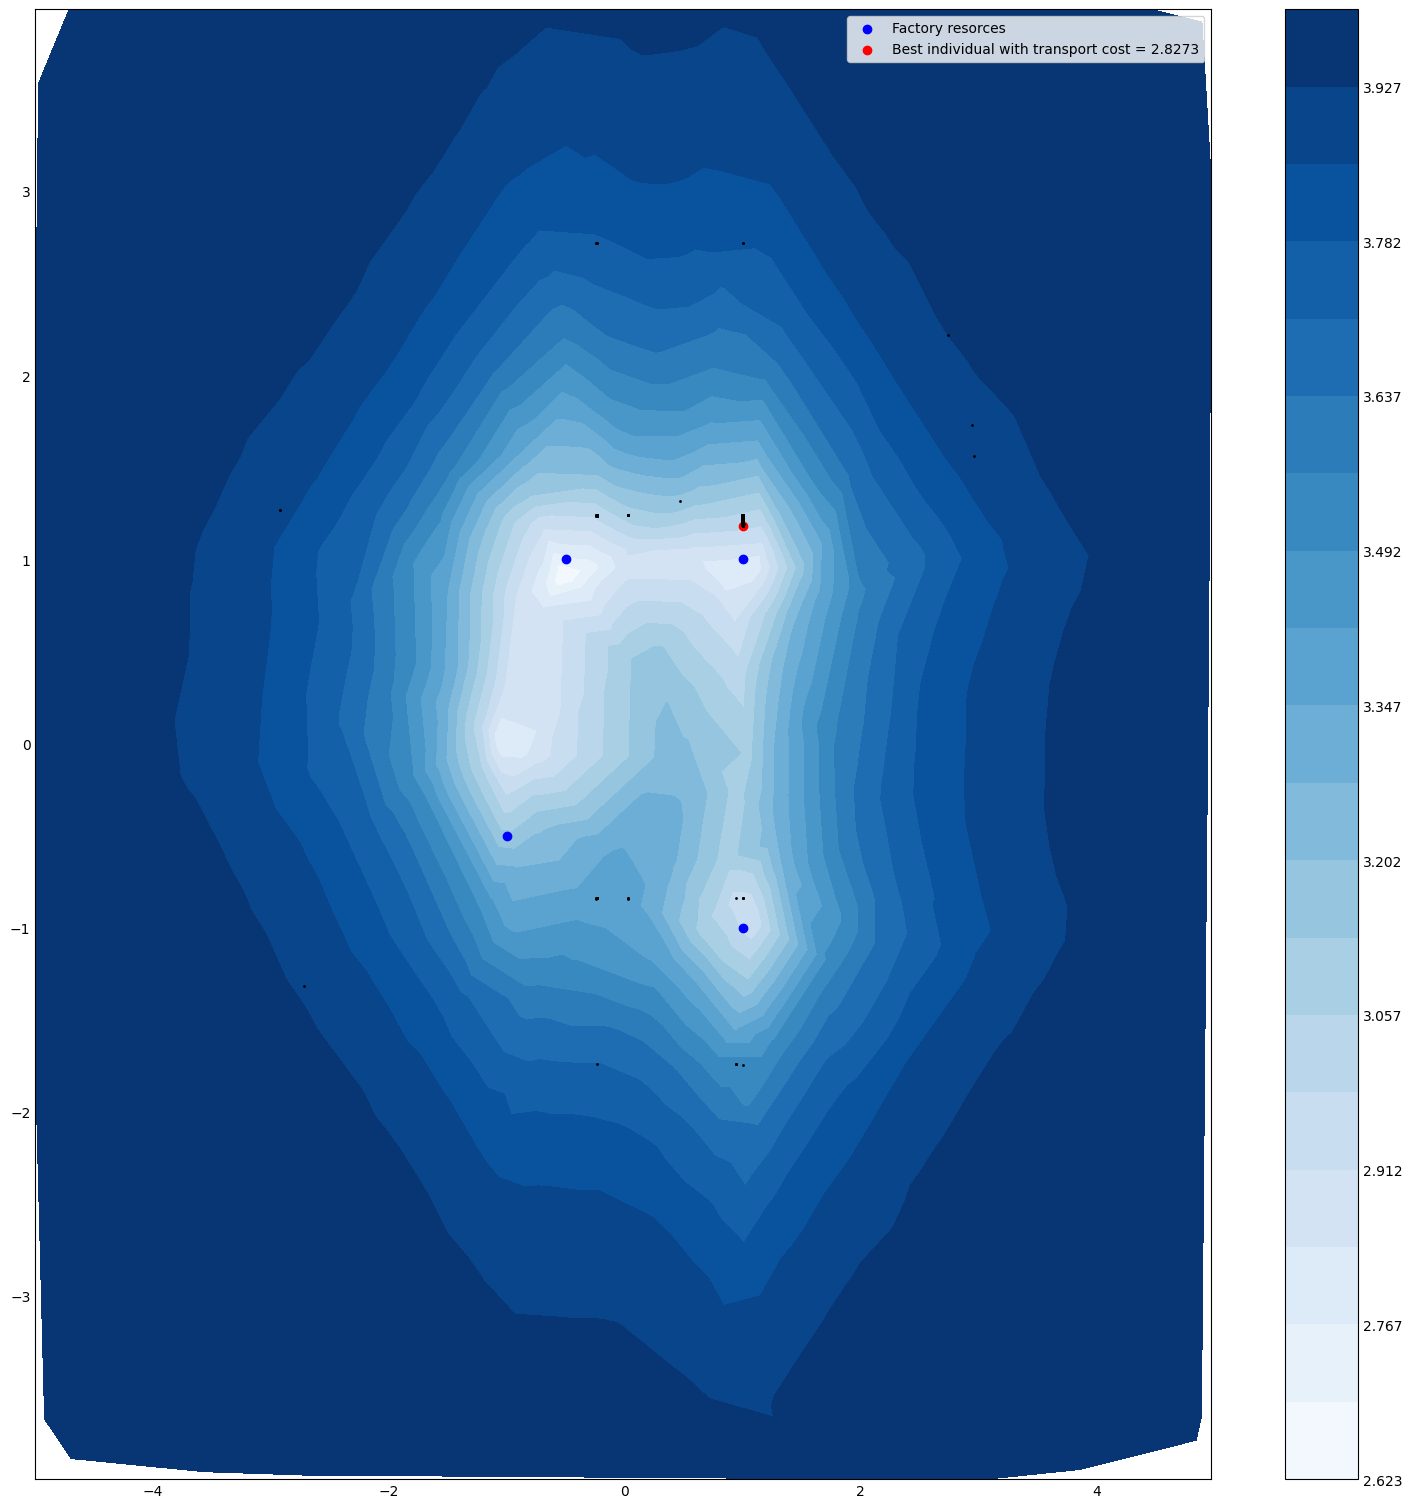

In [13]:
generate_graph_with_parameters(0.001, 0.5, 10, 100)

##### Przypadek zbyt dużej siły mutacji - *1*
- algorytm działa zbyt losowo, miejsca mniej korzystne są niemalże tak samo analizowane jak te, które wskazują na bliskość minima lokalnego/globalnego
- zbyt duże rozproszenie populacji / eksploracja

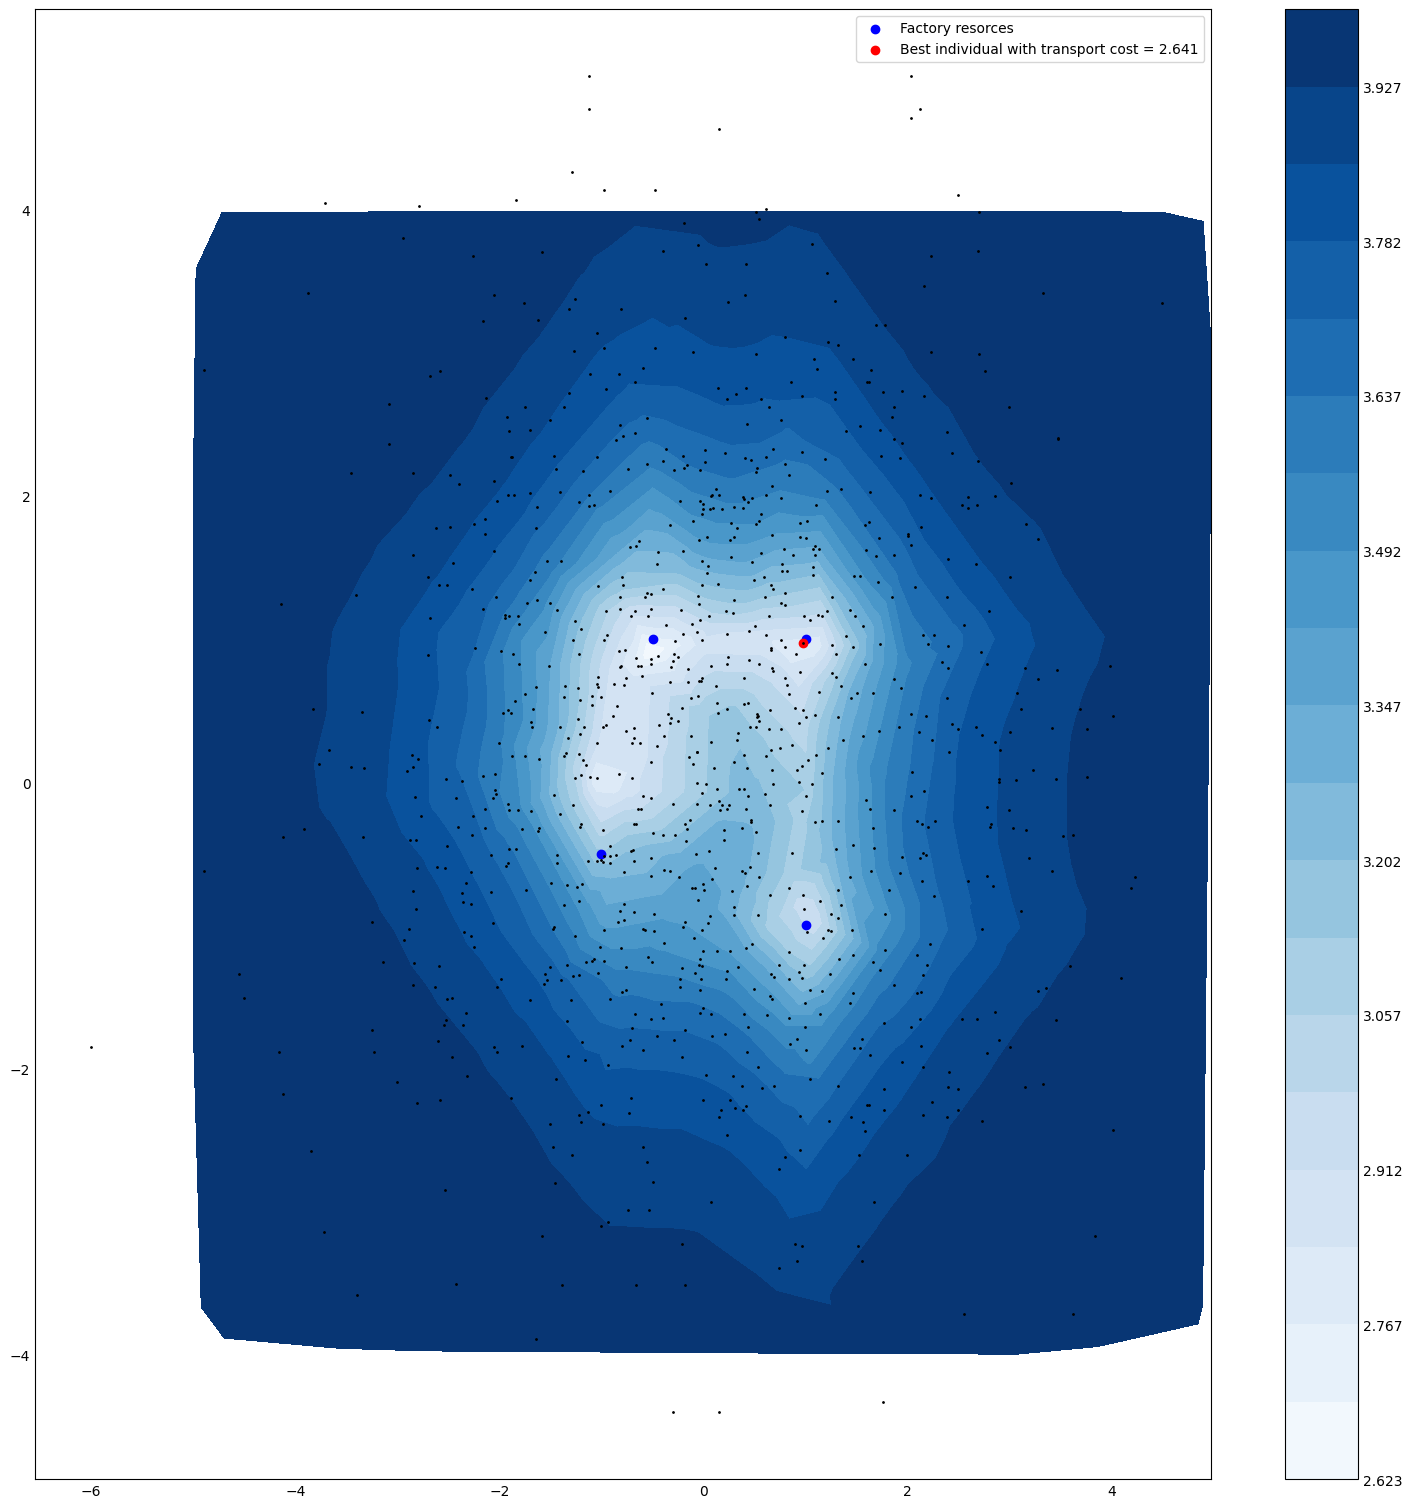

In [14]:
generate_graph_with_parameters(1, 0.5, 10, 100)

#### Wpływ prawdopodobieństwa krzyżowania na działanie algorytmu ewolucyjnego

###### Przypadek, gdy żaden osobnik nie bierze udziału w krzyżowaniu - dla *1*
(W naszej implementacji algorytmu żaden bowiem osobnik nie jest w stanie wylosować prawdopodobieństwa krzyżowania równego 1)

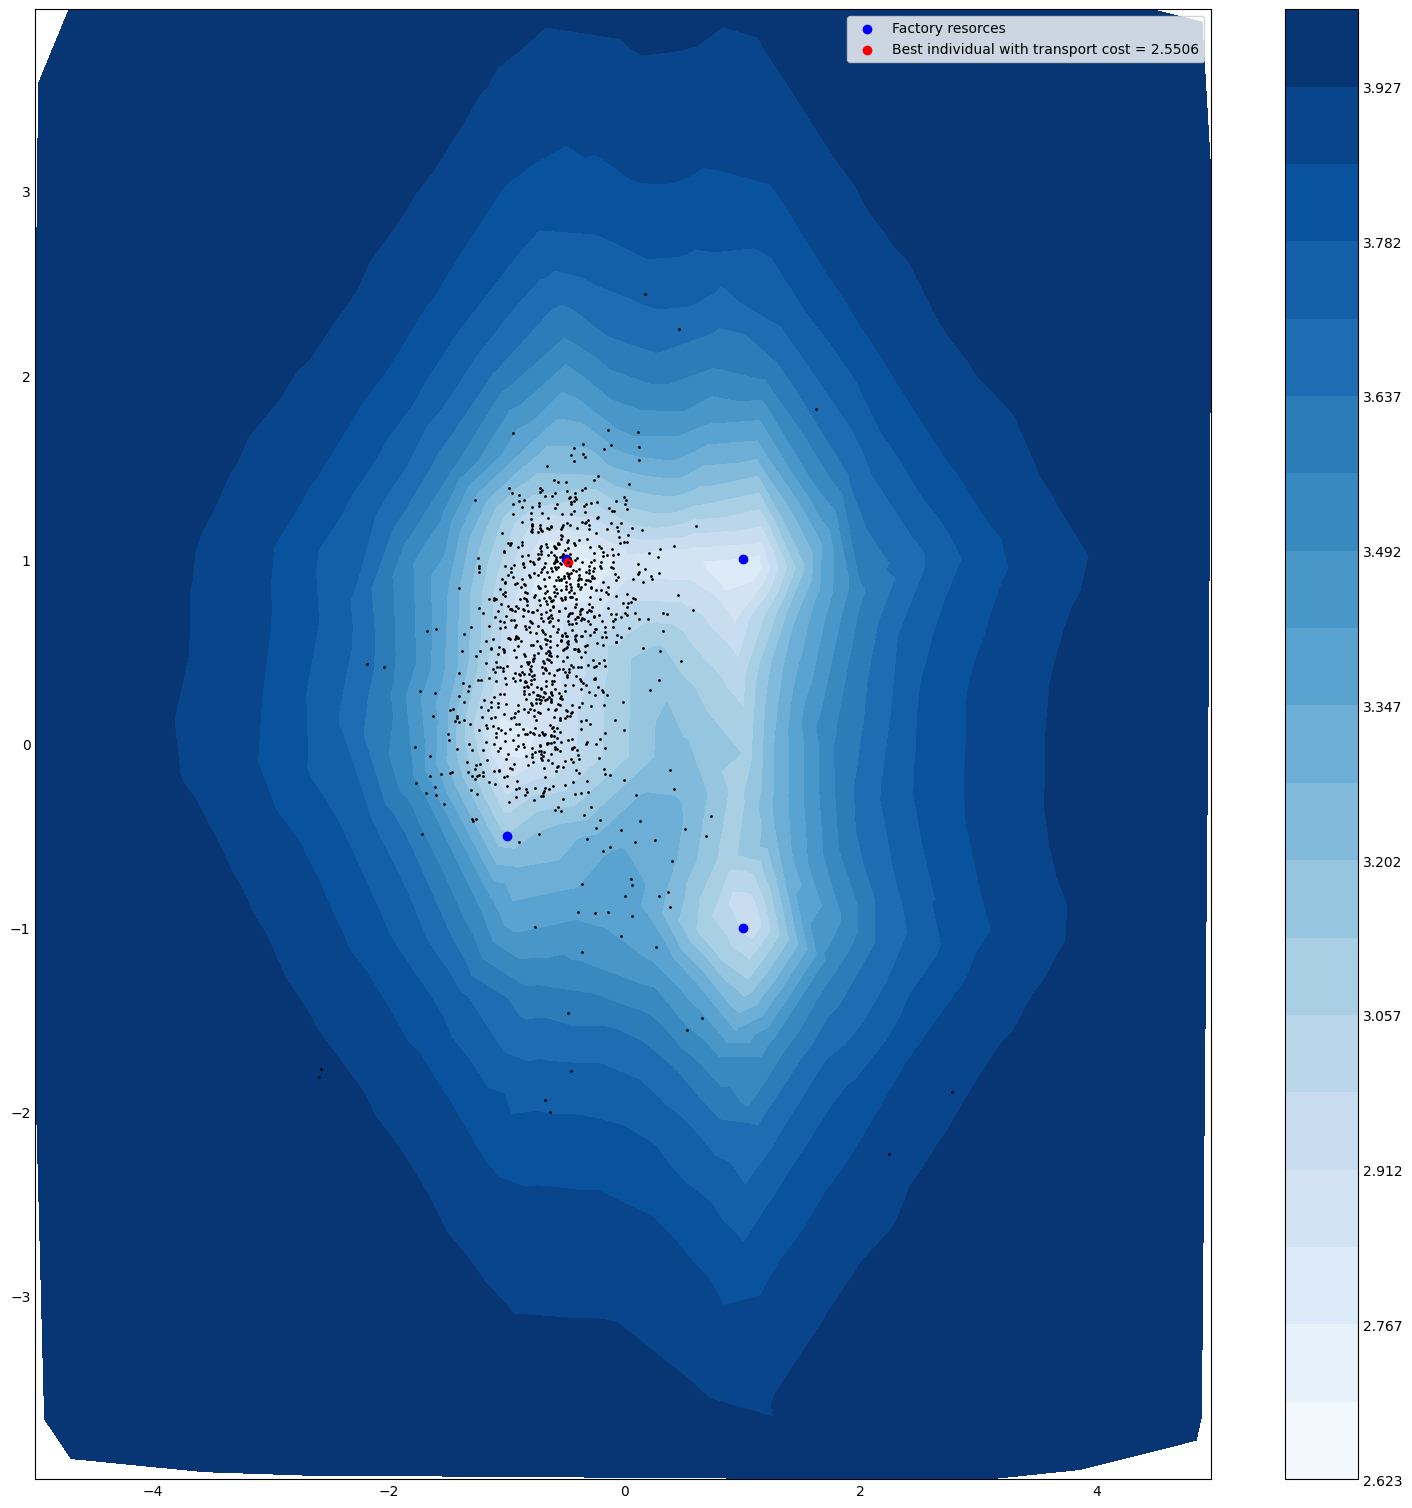

In [15]:
generate_graph_with_parameters(0.2, 1, 10, 100)

###### Przypadek, gdy prawie każdy osobnik bierze udziału w krzyżowaniu - dla *0.001*
(W naszej implementacji bowiem niemal wszystkie osobniki wylosują prawdopodobieństwo większe od 0.001)

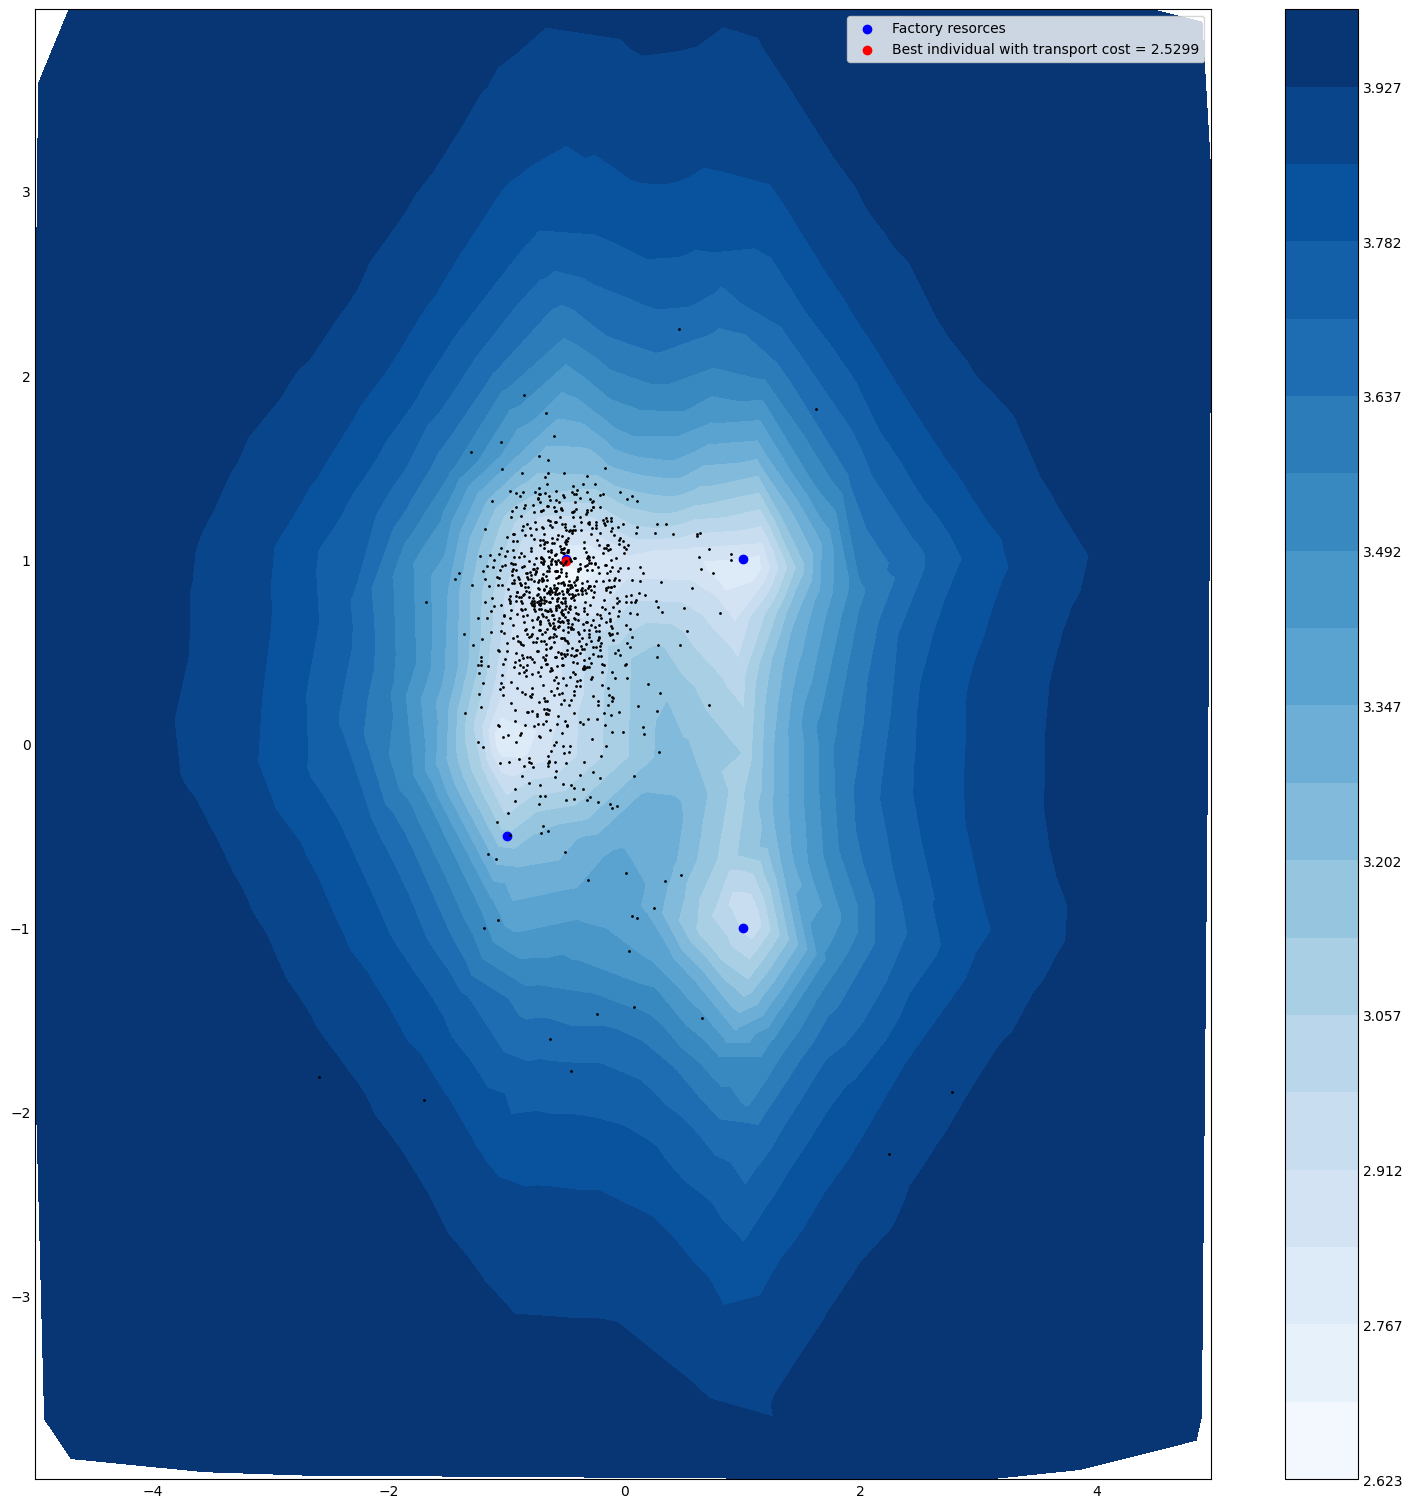

In [16]:
generate_graph_with_parameters(0.2, 0.001, 10, 100)

#### Wpływ wielkości populacji na działanie algorytmu ewolucyjnego

###### Przypadek, zbyt małej populacji - dla populacji składającej się z *2* osobników
- ryzyko nieznalezienia globalnego minimum

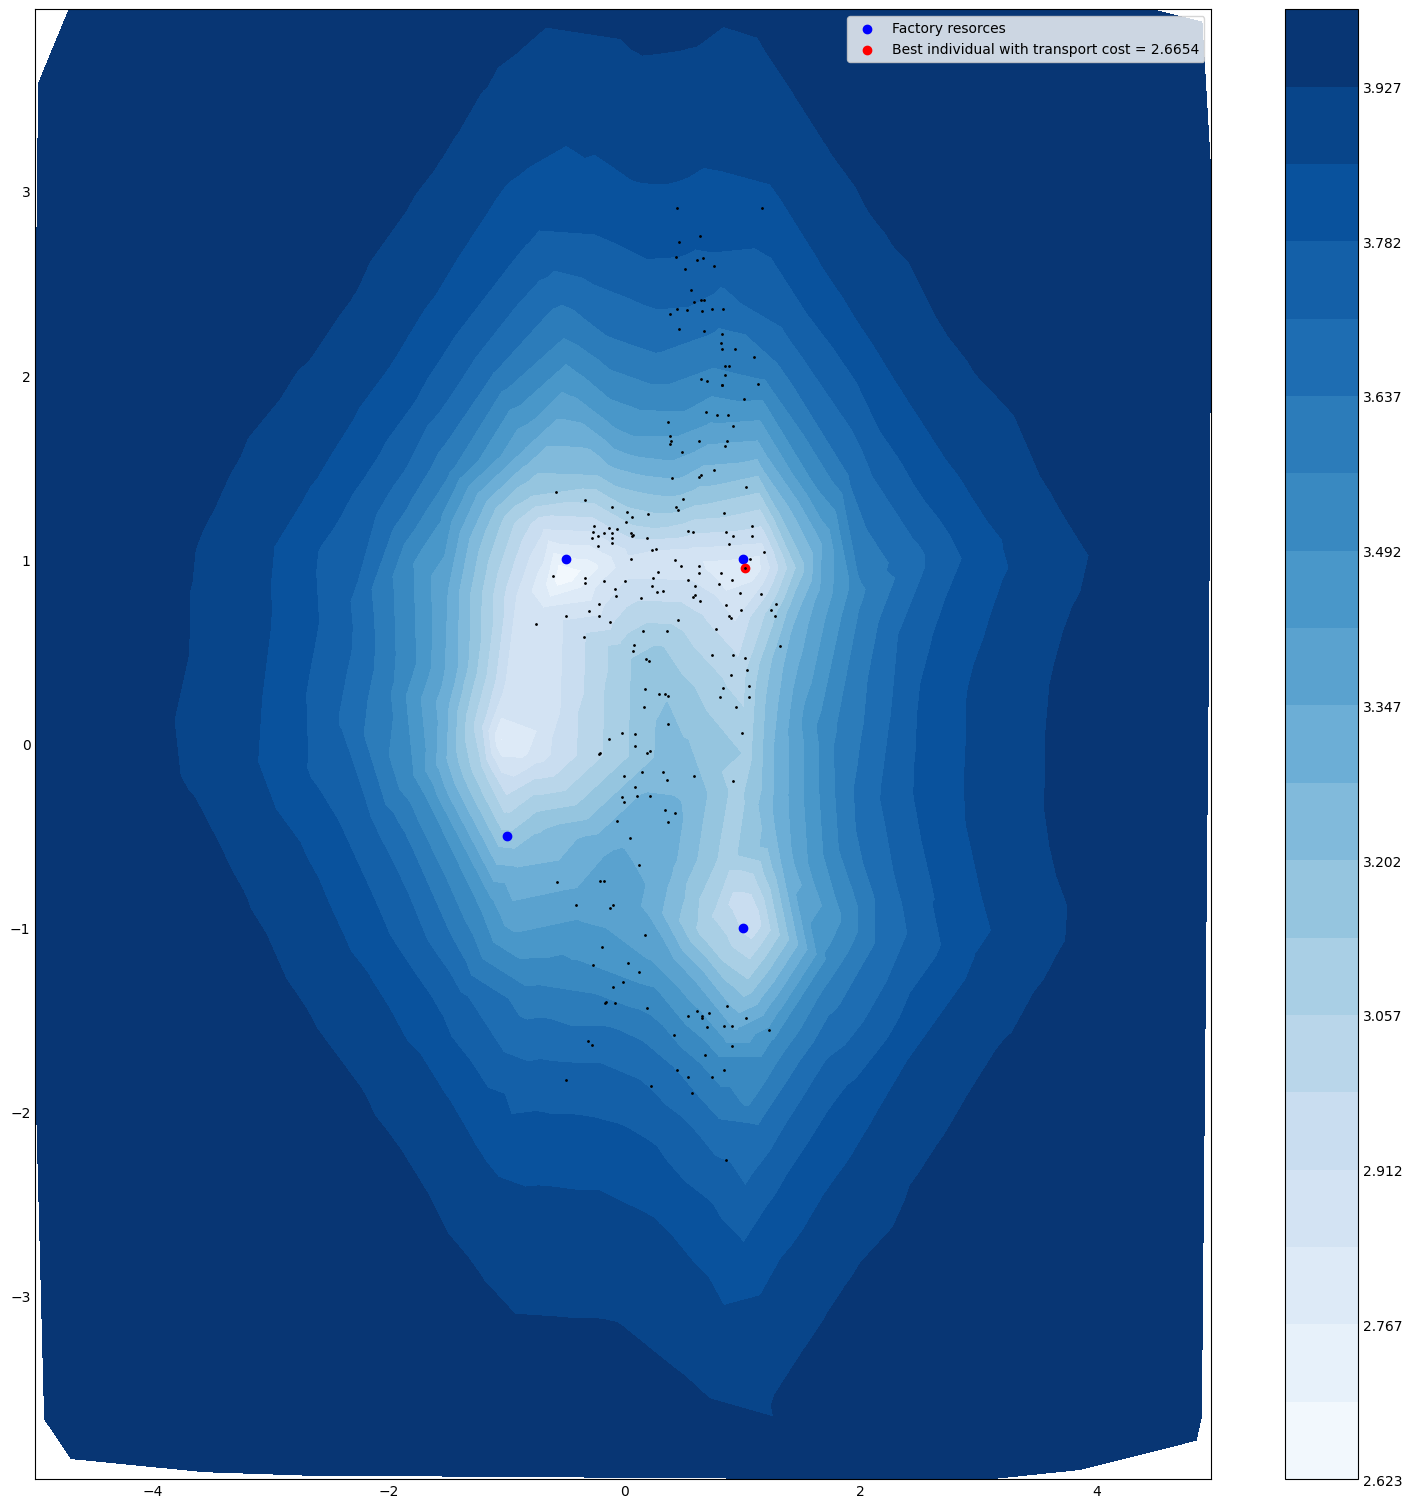

In [17]:
generate_graph_with_parameters(0.2, 0.5, 2, 100)

###### Przypadek, zbyt dużej populacji - dla populacji składającej się z aż *1000* osobników
- zbyt duża populacja (w porównaniu do zadanego problemu) wpływa niekorzystnie na czas działania algorytmu

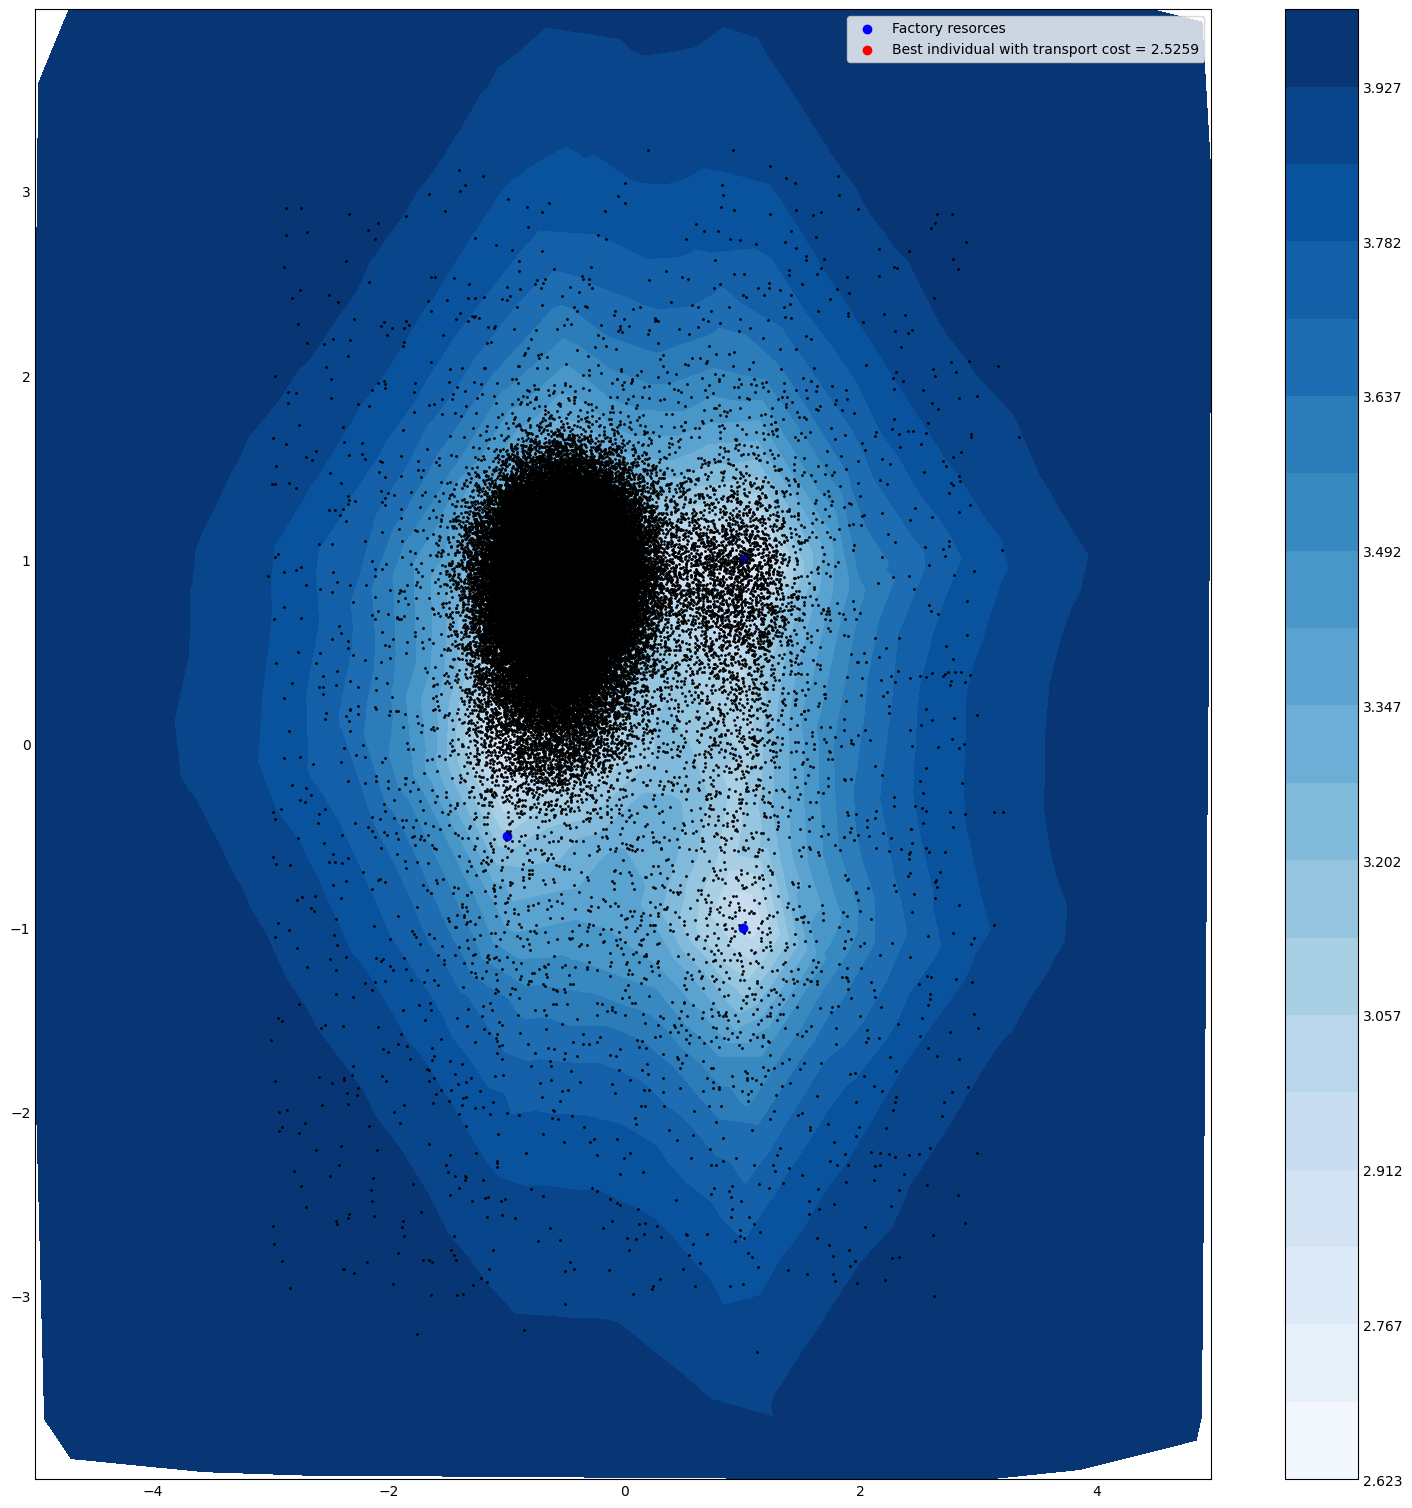

In [18]:
generate_graph_with_parameters(0.2, 0.5, 1000, 100)

#### Wpływ kryterium stopu na działanie algorytmu ewolucyjnego

###### Przypadek, zbyt małego kryterium stopu - dla maksymalnej liczby iteracji równej *10*
- algorytm nie zdążył dokonać eksploracji przestrzeni - istnieje duże ryzyko wskazania błędnego (dotychczas znalezionego) minimum lokalnego

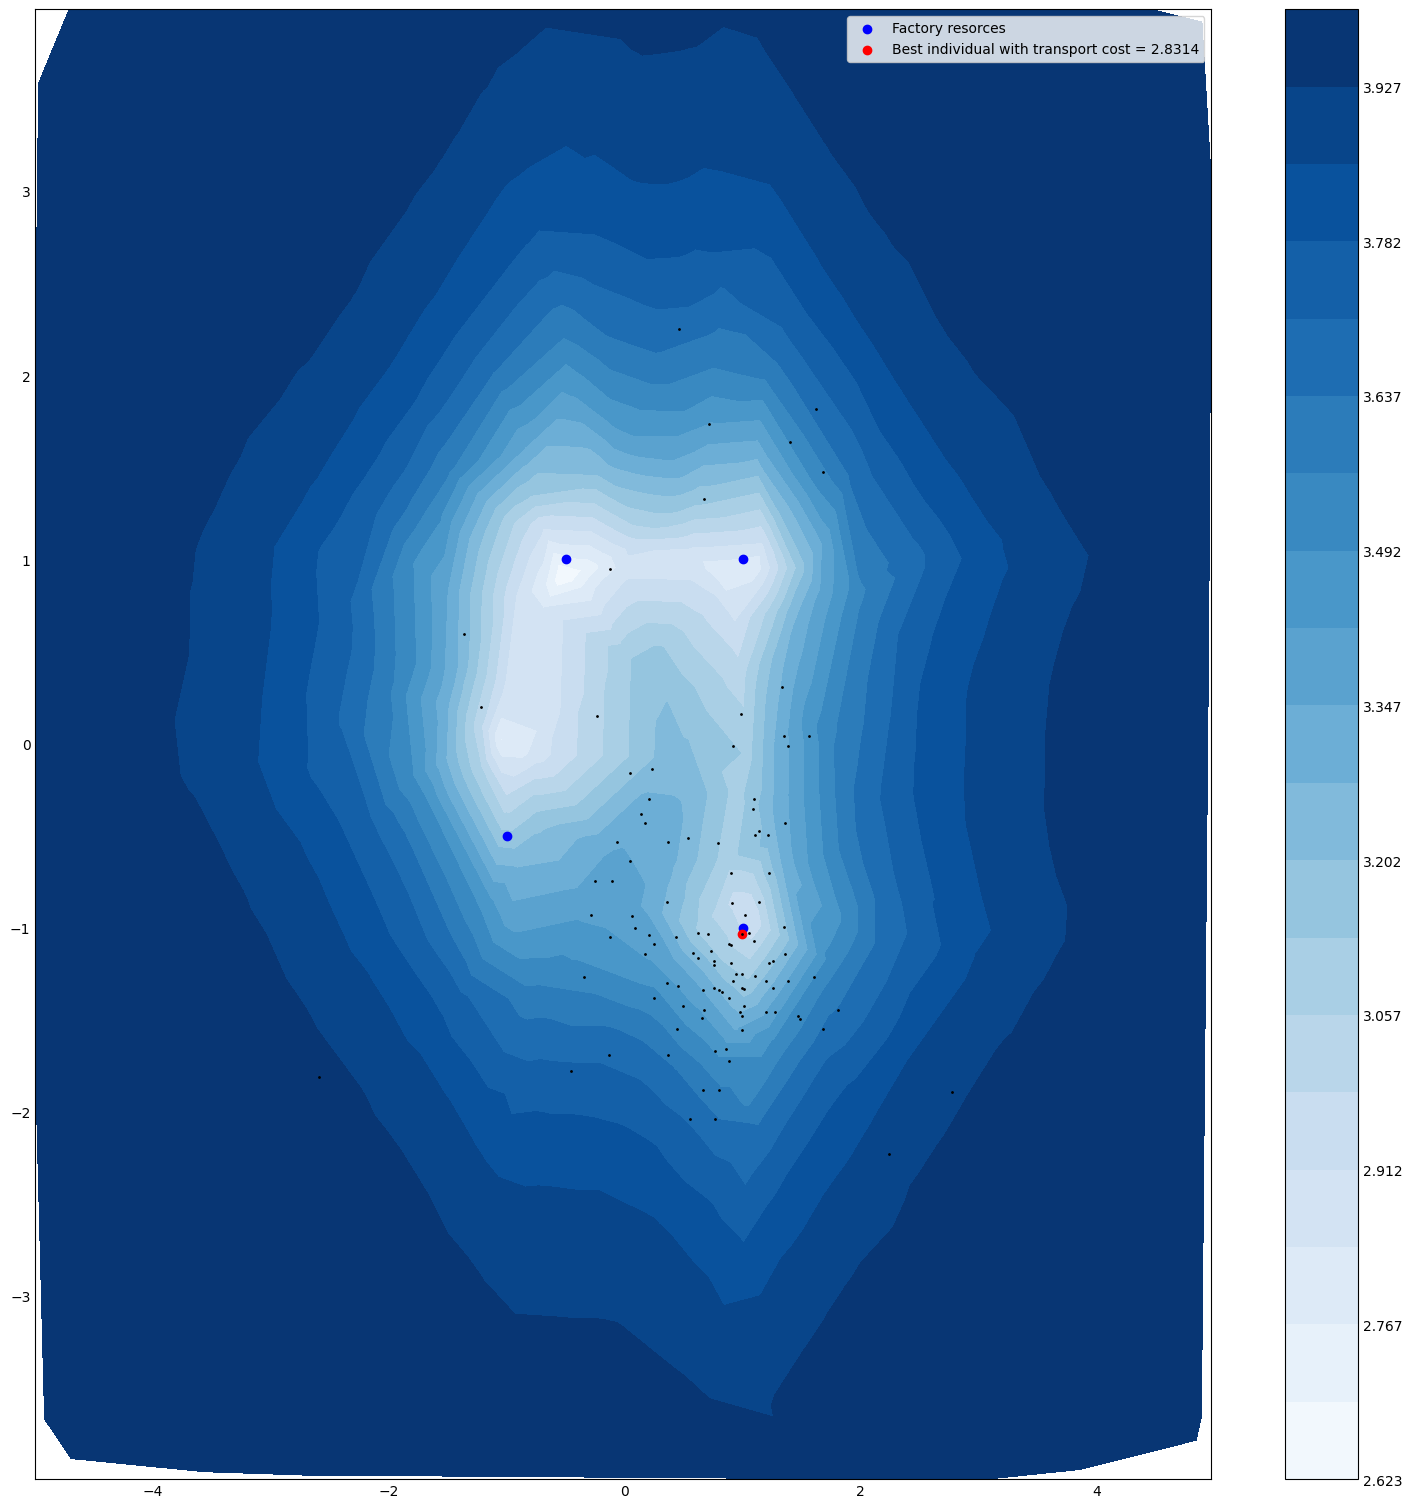

In [19]:
generate_graph_with_parameters(0.2, 0.5, 10, 10)

###### Przypadek, zbyt dużego kryterium stopu - dla maksymalnej liczby iteracji równej aż *1000*
- niekorzystny wpływ na czas pracy algorytmu ewolucyjnego

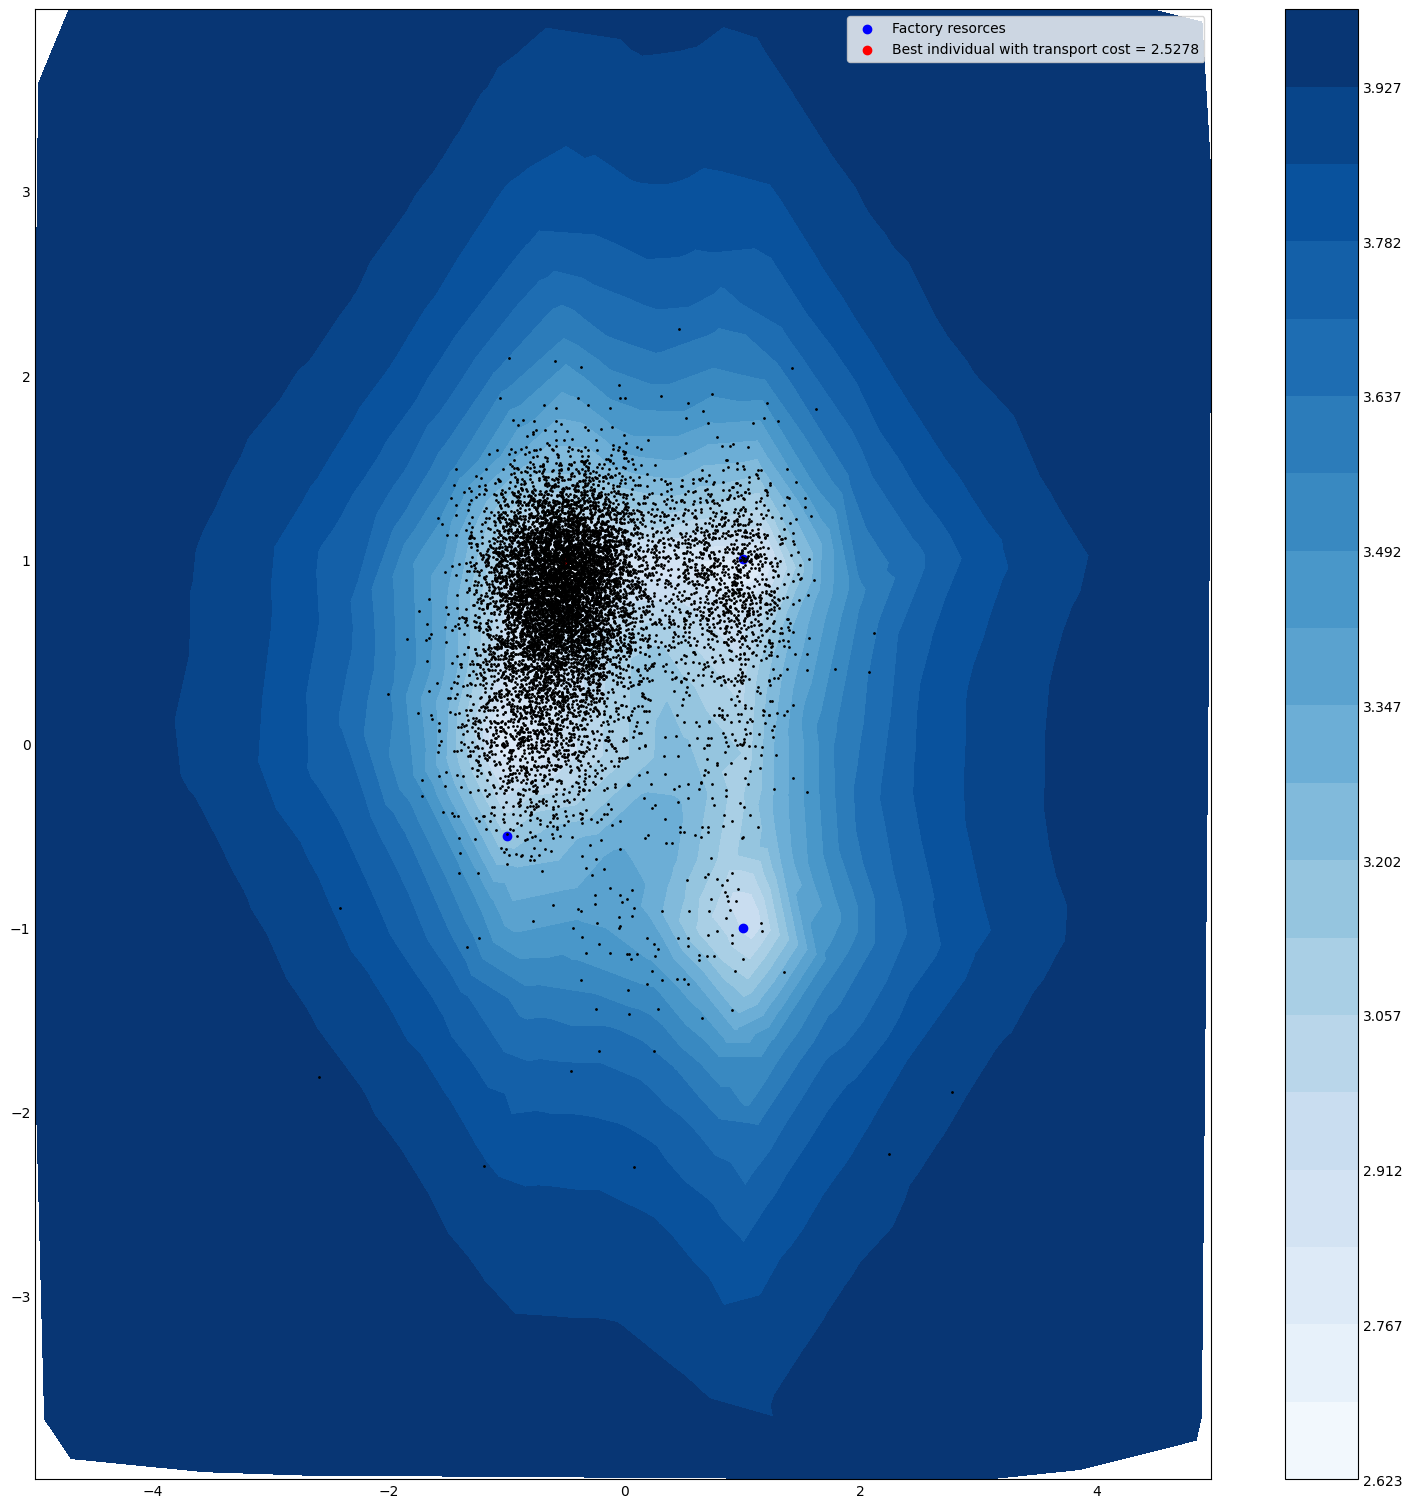

In [20]:
generate_graph_with_parameters(0.2, 0.5, 10, 1000)

### Dobór odpowiednich parametrów działania algorytmu
- parametry powinny zostać dobrane tak, aby algorytm mógł w optymalny sposób przeszukać badaną przestrzeń - powinien on zarówno dokonać jej eksploracji (na większym obszarze) jak i eksploatacji (w miejscach dla nas ciekawych, czyli "podejrzanych o stanowienie sąsiedztwa" minima globalnego). Wówczas możemy być bardziej pewni, że przestrzeń została dokładnie zbadana, a wynik wskazany przez algorytm faktycznie stanowi minimum globalne.

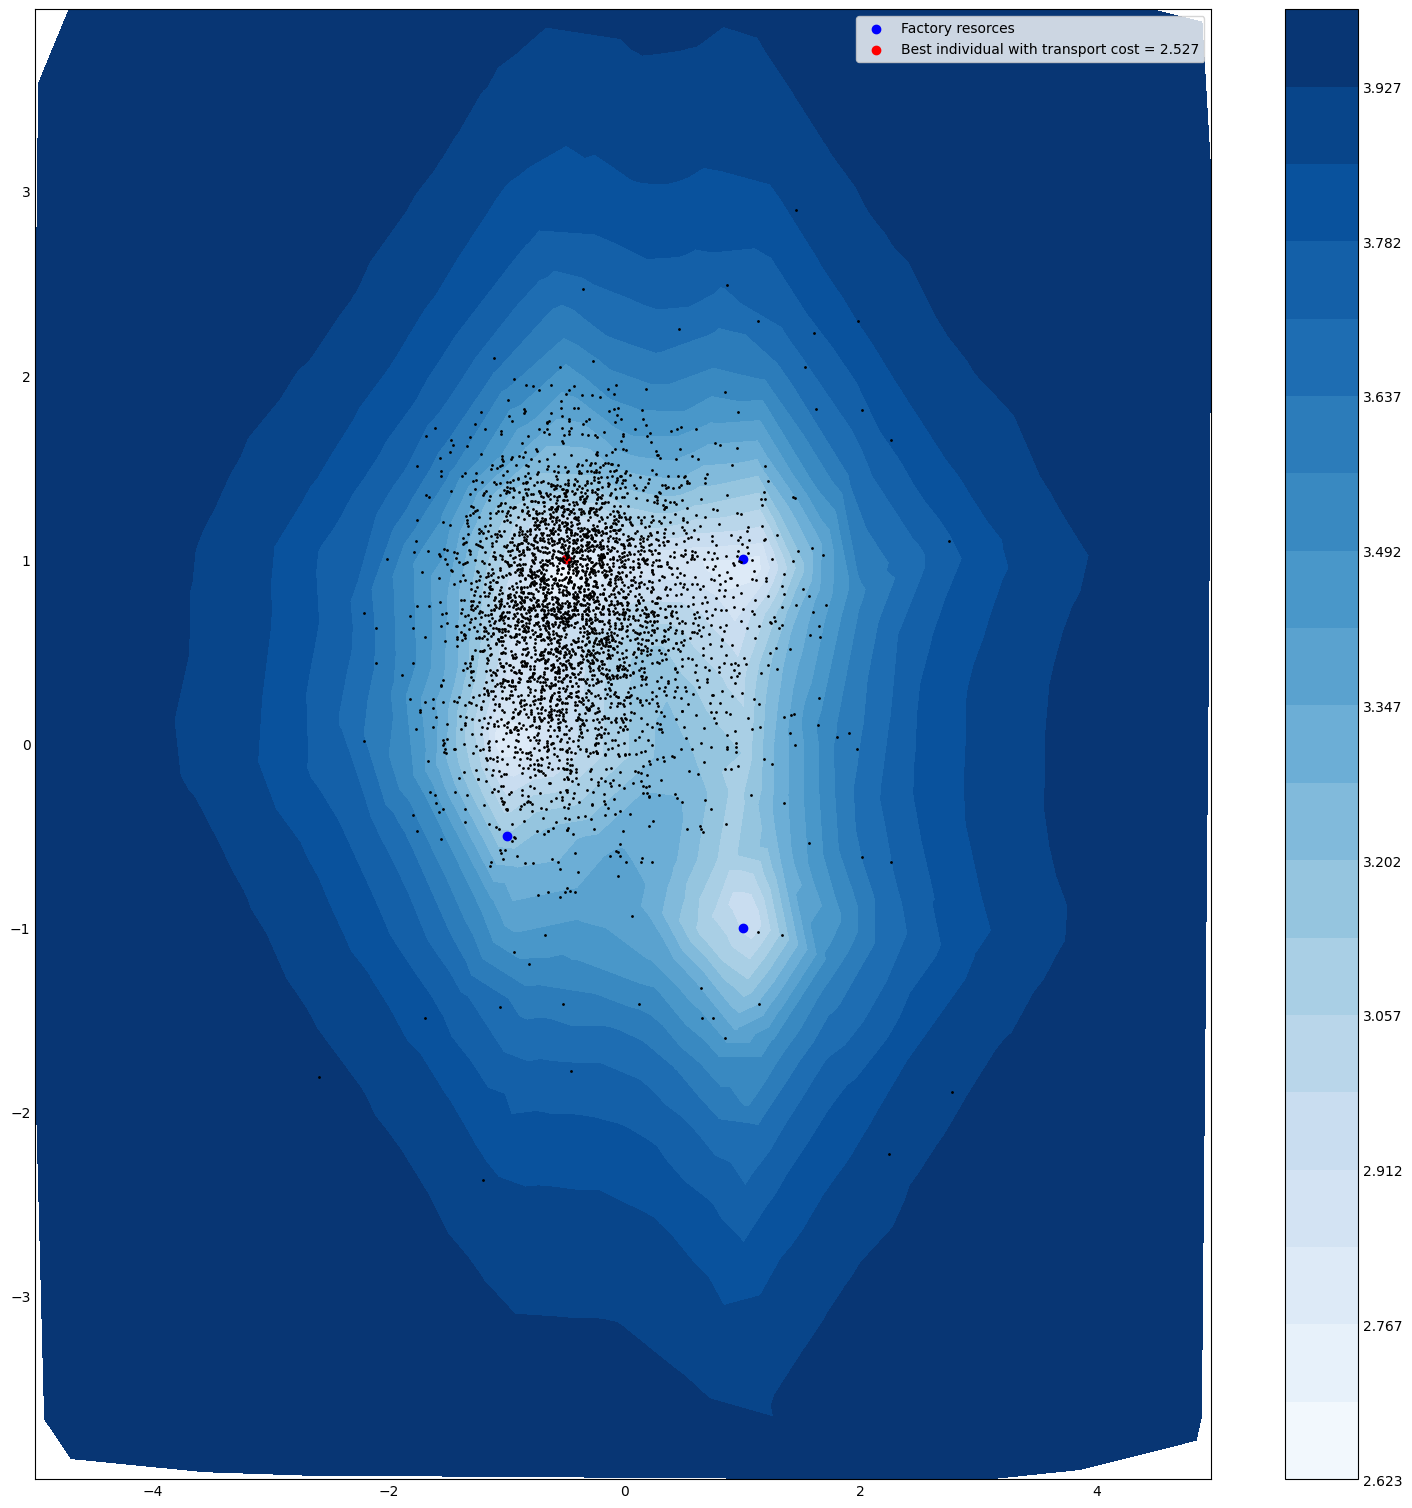

In [21]:
generate_graph_with_parameters(0.3, 0.3, 15, 250)

## Wnioski
- nie istnieje jednoznaczny sposób wyznaczenia parametrów algorytmu ewolucyjnego - argumenty funkcji algorytmu powinny zostać dobrane w zależności od złożoności oraz wielkości problemu - np. rozmiaru badanego obszaru, liczby potencjalnych minimów lokalnych. W rzeczywistości dlatego bardzo często do rozwiązania danego problemu musimy powołać się o wiedzę ekspercką, która nakieruje nas na poprawne dobranie hiperparametrów. W sytuacji, gdy takowej wiedzy nie posiadamy jesteśmy poniekąd skazani na dobór parametrów "metodą prób i błędów". Ważne, żeby dobrać parametry tak, aby nasz algorytm w sposób jak najbardziej korzystny przeszukał naszą przestrzeń (mając też na względzie optymalny czas działania algorytmu).